## <span style="color: Orange;">**Neural Network Model**</span>
Environment setup, config-driven data loading, two MLPs (engineered/raw), Lightning training, evaluation, permutation importance, and combined-feature retraining workflow summarized below.

**Index**
- [Section I: Environment Setup and Reproducibility](#section-i-environment-setup-and-reproducibility)
- [Section II: Configuration, Dataset Preparation, and DataLoaders](#section-ii-configuration-dataset-preparation-and-dataloaders)
- [Section III: Model Architecture and Training Module](#section-iii-model-architecture-and-training-module)
- [Section IV: Engineered Features Training and Monitoring (ENG Pool)](#section-iv-engineered-features-training-and-monitoring-eng-pool)
- [Section V: Evaluation — Classification Reports (ENG Pool)](#section-v-evaluation--classification-reports-eng-pool)
- [Section VI: Permutation Feature Importance (ENG Pool)](#section-vi-permutation-feature-importance-eng-pool)
- [Section VII: Raw Features Training and Monitoring (RAW Pool)](#section-vii-raw-features-training-and-monitoring-raw-pool)
- [Section VIII: Evaluation — Classification Reports (RAW Pool)](#section-viii-evaluation--classification-reports-raw-pool)
- [Section IX: Permutation Feature Importance (RAW Pool)](#section-ix-permutation-feature-importance-raw-pool)
- [Section X: Feature Selection and Combined-Feature Training](#section-x-feature-selection-and-combined-feature-training)

**Notebook summary**

- The workflow begins by enforcing deterministic behavior and mixed-precision preferences, then loads dataset paths and runtime parameters from YAML for reproducible, configurable experiments.  
- Datasets for engineered and raw features are prepared with train/validation/test splits and wrapped in efficient DataLoaders to support GPU training and fast I/O.  
- Separate MLPs for each feature pool are defined and encapsulated in a training module that handles optimization, logging, and malignant-class recall tracking per epoch.  
- Each model is trained with GPU acceleration and cosine-annealed learning rates, followed by validation/test classification reports to compare precision, recall, F1, and accuracy.  
- Permutation importance on the validation split quantifies feature influence for both pools; important features are selected via a simple threshold on mean accuracy drop.  
- A combined dataset is built from the union of selected features, a corresponding


### <span style="color: Orange;">**Section I: Environment Setup and Reproducibility**</span>

- Configure deterministic behavior for CUDA operations  
- Import essential Python, data science, and PyTorch libraries  
- Set seed values across libraries to ensure reproducible results  

In this section, we begin by configuring the environment to promote reproducible and stable training runs. The `CUBLAS_WORKSPACE_CONFIG` environment variable is set before importing PyTorch to enforce deterministic behavior for certain CUDA operations. After this, we import frequently used libraries for data handling, visualization, and deep learning. Additionally, PyTorch’s floating-point precision mode is adjusted to `'medium'` for improved performance during F32 matrix multiplications. To guarantee experiment reproducibility, a `set_seed` function is defined to seed Python’s `random`, NumPy, and PyTorch (CPU and GPU) operations. This also controls deterministic execution policies in PyTorch’s backend, ensuring that results remain consistent across multiple runs of the notebook.  


In [30]:
# Set environment variable for determinism before import Torch
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [31]:
# Importing the libraries and setting the floating point precision to medium for F32 calculation for performance gains
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn as nn
import torch
import torch.nn.functional as F
torch.set_float32_matmul_precision('medium')

In [32]:
# Seeding the notebook session for reproducible workflow
def set_seed(seed: int = 42, deterministic: bool = True):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        try:
            torch.use_deterministic_algorithms(True)
        except Exception:
            pass
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

set_seed(42, deterministic=True)

### <span style="color: Orange;">**Section II: Configuration, Dataset Preparation, and DataLoaders**</span>

- Read notebook-specific configurations from an external YAML file  
- Define a custom `CancerDataset` class for structured dataset handling  
- Initialize engineered and raw feature datasets (train/val/test splits)  
- Wrap datasets with PyTorch `DataLoader` for efficient batching and parallel loading  

In this section, we load notebook-level configurations from a YAML file to ensure flexibility and external control over dataset paths and neural network settings such as batch size, worker threads, memory pinning, and persistent workers. A custom dataset class, `CancerDataset`, is implemented to handle CSV-based feature and target files, optionally applying feature selection and validating input consistency. This class converts features and labels into NumPy arrays and subsequently into PyTorch tensors, making them directly usable in training pipelines. After dataset initialization for both **engineered features** and **raw features**, PyTorch `DataLoader` objects are created for each split (train, validation, test), enabling shuffling, multiprocessing, and optimized GPU memory transfer during model training and evaluation.


In [33]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

    batch_size = config['nn_config']['batch_size']
    num_workers = config['nn_config']['num_workers']
    pin_memory = config['nn_config']['pin_memory']
    persistent_workers = config["nn_config"]['persistent_workers']

In [34]:
class CancerDataset(Dataset):
    def __init__(self, feature_path, target_path, use_filter=False, feature_filter=None, dtype_feat="float32"):
        super().__init__()
        dfX = pd.read_csv(feature_path)
        y = pd.read_csv(target_path).squeeze()

        if use_filter and feature_filter:
            missing = [c for c in feature_filter if c not in dfX.columns]
            if missing:
                raise ValueError(f"Columns not found in {feature_path}: {missing}")
            dfX = dfX.loc[:, feature_filter]

        # Store as numpy arrays
        self.features = dfX.to_numpy(dtype=dtype_feat, copy=True)
        self.targets = y.to_numpy(dtype="int64", copy=True)

        if len(self.features) != len(self.targets):
            raise ValueError(f"Row count mismatch: X={len(self.features)} vs y={len(self.targets)}")

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.features[idx])
        y = torch.tensor(self.targets[idx], dtype=torch.int64)
        return x, y

train_dataset_eng = CancerDataset(X_train_eng, y_train_eng)
val_dataset_eng = CancerDataset(X_val_eng, y_val_eng)
test_dataset_eng = CancerDataset(X_test_eng, y_test_eng)

train_dataset_raw = CancerDataset(X_train_raw, y_train_raw)
val_dataset_raw = CancerDataset(X_val_raw, y_val_raw)
test_dataset_raw = CancerDataset(X_test_raw, y_test_raw)

In [35]:
train_loader_eng = DataLoader(
    train_dataset_eng,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
val_loader_eng = DataLoader(
    val_dataset_eng,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
test_loader_eng = DataLoader(
    test_dataset_eng,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

train_loader_raw = DataLoader(
    train_dataset_raw,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
val_loader_raw = DataLoader(
    val_dataset_raw,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
test_loader_raw = DataLoader(
    test_dataset_raw,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

### <span style="color: Orange;">**Section III: Model Architecture and Training Module**</span>

- Define separate MLP-based models for engineered and raw features  
- Use batch normalization, ReLU activations, and dropout for stability and regularization  
- Wrap models inside a PyTorch Lightning module (`LitModel`) to streamline training and evaluation  
- Implement epoch-level malignant recall tracking for deeper performance analysis  

This section introduces the deep learning model design. Two feedforward neural network classes, `EngModel` (for engineered features) and `RawModel` (for raw features), are implemented as multi-layer perceptrons (MLPs) with linear layers, batch normalization, ReLU activations, and dropout for regularization. Both architectures are designed to project high-dimensional input features into class predictions.  
To simplify and standardize the training pipeline, a custom PyTorch Lightning module (`LitModel`) is defined. This wrapper encapsulates the underlying model while handling forward propagation, training and validation steps, optimizer setup, and learning-rate scheduling. In addition to standard logging of loss values, the module accumulates predictions and targets across each epoch to compute **recall for the malignant class**, a clinically significant metric in cancer detection. This ensures that the model is evaluated not only on overall loss but also on its ability to correctly identify malignant cases, which is critical in such domains.  


In [36]:
# Model Definitions
class EngModel(nn.Module):
    def __init__(self, input_features, num_classes):
        super(EngModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.mlp(x)
        return x

class RawModel(nn.Module):
    def __init__(self, input_features, num_classes):
        super(RawModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [37]:
import lightning as L
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report

class LitModel(L.LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
        min_eta: float = 1e-5,
        max_epochs: int = 10,
    ):
        super().__init__()
        self.model = model
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.min_eta = min_eta
        self.max_epochs = max_epochs

        # Learning-curve accumulators: malignant (class 1) recall per epoch
        self.train_recall_mal_accum = []
        self.val_recall_mal_accum = []

        # Per-epoch caches for preds/targets (used ONLY to compute malignant recall)
        self.train_preds_epoch = []
        self.train_targets_epoch = []
        self.val_preds_epoch = []
        self.val_targets_epoch = []

    def forward(self, x):
        return self.model(x)

    # ------------------- TRAINING -------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        # cache for per-class recall via sklearn after epoch
        self.train_preds_epoch.append(preds.detach().cpu())
        self.train_targets_epoch.append(y.detach().cpu())

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        return loss

    def on_train_epoch_end(self):
        # Compute malignant recall from cached preds/targets
        if self.train_preds_epoch:
            preds = torch.cat(self.train_preds_epoch)
            targets = torch.cat(self.train_targets_epoch)
            self.train_preds_epoch.clear()
            self.train_targets_epoch.clear()

            rep = classification_report(
                targets.numpy(),
                preds.numpy(),
                labels=[0, 1],
                target_names=["Benign", "Malignant"],
                output_dict=True,
                zero_division=0,
            )
            mal_recall = rep.get("Malignant", {}).get("recall", 0.0)
            self.train_recall_mal_accum.append(float(mal_recall))
        else:
            self.train_recall_mal_accum.append(0.0)

    # ------------------- VALIDATION -------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.val_preds_epoch.append(preds.detach().cpu())
        self.val_targets_epoch.append(y.detach().cpu())

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        return loss

    def on_validation_epoch_end(self):
        if self.val_preds_epoch:
            preds = torch.cat(self.val_preds_epoch)
            targets = torch.cat(self.val_targets_epoch)
            self.val_preds_epoch.clear()
            self.val_targets_epoch.clear()

            rep = classification_report(
                targets.numpy(),
                preds.numpy(),
                labels=[0, 1],
                target_names=["Benign", "Malignant"],
                output_dict=True,
                zero_division=0,
            )
            mal_recall = rep.get("Malignant", {}).get("recall", 0.0)
            self.val_recall_mal_accum.append(float(mal_recall))
        else:
            self.val_recall_mal_accum.append(0.0)

    # ------------------- OPTIMIZER / SCHEDULER -------------------
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.max_epochs, eta_min=self.min_eta
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

### <span style="color: Orange;">**Section IV: Engineered Features Training and Monitoring (ENG Pool)**</span>

- Initialize a Lightning trainer with GPU acceleration and mixed precision (16-bit autocast)
- Train the engineered-features MLP with cosine annealing learning-rate scheduling
- Plot epoch-wise malignant-class recall to monitor class-sensitive learning

This section configures and runs training for the engineered-features model using a GPU-accelerated trainer with mixed precision to improve throughput and reduce memory usage while preserving FP32 stability for weights. The engineered MLP is wrapped in the Lightning training module and optimized over a fixed epoch budget with CosineAnnealingLR, which smoothly decays the learning rate toward a specified floor without restarts. During training and validation, malignant-class recall is accumulated per epoch to emphasize sensitivity to the positive class; the provided plotting helper then visualizes training and validation recall trajectories, enabling quick checks for generalization gaps, instability, or underfitting.


In [38]:
max_epochs = 20

model_eng = LitModel(
    EngModel(input_features=train_dataset_eng[0][0].shape[0], num_classes=2),
    learning_rate=1e-3,
    max_epochs=max_epochs
)

trainer_eng = L.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu',
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed',        
    logger=False,        
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    num_sanity_val_steps=0
)
trainer_eng.fit(model_eng, train_loader_eng, val_loader_eng)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\bcd_mal\venv\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | EngModel | 139 K  | train
-------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [39]:
def plot_epoch_learning_curve(train_scores, val_scores, title="Learning Curve (Malignant Recall)", ylim=(0.0, 1.05)):
    epochs = np.arange(1, len(train_scores) + 1)

    train_scores = np.asarray(train_scores, dtype=float)
    val_scores = np.asarray(val_scores, dtype=float)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_scores, 'o-', color='blue', label='Training recall (label=1)')
    plt.plot(epochs, val_scores, 'o-', color='green', label='Validation recall (label=1)')

    # Optional: shaded band for a simple smoothing uncertainty proxy (rolling std)
    # Comment out if not desired
    if len(train_scores) >= 3:
        k = 3
        tr_roll = np.array([train_scores[max(0,i-k+1):i+1].std() for i in range(len(train_scores))])
        vl_roll = np.array([val_scores[max(0,i-k+1):i+1].std() for i in range(len(val_scores))])
        plt.fill_between(epochs, train_scores - tr_roll, train_scores + tr_roll, color='blue', alpha=0.10)
        plt.fill_between(epochs, val_scores - vl_roll, val_scores + vl_roll, color='green', alpha=0.10)

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Recall (malignant class)')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

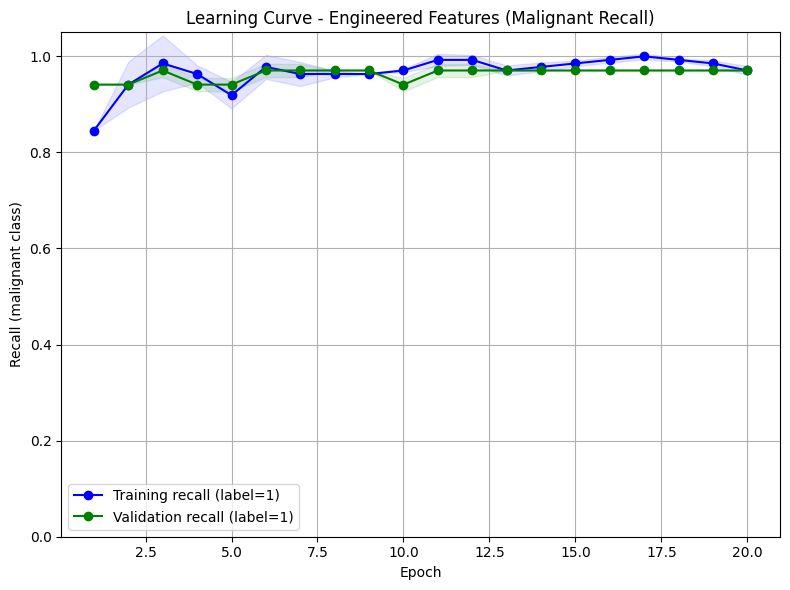

In [40]:
plot_epoch_learning_curve(
    model_eng.train_recall_mal_accum,
    model_eng.val_recall_mal_accum,
    title="Learning Curve - Engineered Features (Malignant Recall)"
)

### <span style="color: Orange;">**Section V: Evaluation — Classification Reports (ENG Pool)**</span>

- Switch the trained Lightning module to evaluation mode and disable grad
- Run inference over a dataloader, aggregate predictions and targets
- Generate a per-class precision/recall/F1 report for Benign and Malignant

This section implements a utility to compute and display detailed classification metrics for the engineered-features model. The helper sets the module to eval mode with gradients off, iterates through the given dataloader on the correct device, and collects batch-wise predictions alongside ground-truth labels. After concatenation, it prints a scikit-learn classification report (precision, recall, F1-score, support) for the Benign and Malignant classes with consistent label ordering and safe handling of zero-division. The function is then applied to both the validation and test splits to provide an objective post-training assessment of class-wise performance.


In [41]:
@torch.no_grad()
def eval_classification_report(pl_module: L.LightningModule, dataloader, set_name="Validation"):
    pl_module.eval()
    device = next(pl_module.parameters()).device

    preds_all, targets_all = [], []
    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device).long()
        logits = pl_module(xb)
        preds = torch.argmax(logits, dim=1)
        preds_all.append(preds.cpu())
        targets_all.append(yb.cpu())

    y_true = torch.cat(targets_all).numpy()
    y_pred = torch.cat(preds_all).numpy()

    print(f"\n{set_name} Classification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=[0, 1],
        target_names=["Benign", "Malignant"],
        digits=4,
        zero_division=0
    ))
    return y_true, y_pred

In [42]:
y_val_true, y_val_pred = eval_classification_report(model_eng, val_loader_eng, set_name="Validation")
y_test_true, y_test_pred = eval_classification_report(model_eng, test_loader_eng, set_name="Test")


Validation Classification Report:
              precision    recall  f1-score   support

      Benign     0.9828    1.0000    0.9913        57
   Malignant     1.0000    0.9706    0.9851        34

    accuracy                         0.9890        91
   macro avg     0.9914    0.9853    0.9882        91
weighted avg     0.9892    0.9890    0.9890        91


Test Classification Report:
              precision    recall  f1-score   support

      Benign     0.9861    0.9861    0.9861        72
   Malignant     0.9762    0.9762    0.9762        42

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114



### <span style="color: Orange;">**Section VI: Permutation Feature Importance (ENG Pool)**</span>

- Convert dataloader batches to arrays and compute a baseline accuracy
- Wrap the Lightning module in a scikit-learn–compatible estimator stub
- Compute permutation importance on the validation split and visualize ranked importances

This section quantifies feature contributions for the engineered-features model using permutation importance, a model-agnostic inspection method. After extracting arrays and the baseline accuracy from the validation loader, the trained Lightning module is wrapped with a minimal estimator that exposes predict, enabling seamless use of scikit-learn’s permutation_importance API. The routine shuffles each feature across repeated trials and measures the average decrease in accuracy; the resulting means and standard deviations are tabulated and plotted as a horizontal bar chart, highlighting features whose perturbations most degrade validation accuracy. The top rows of the resulting DataFrame provide a quick view of the most influential engineered features.


In [43]:
import numpy as np
import pandas as pd
import torch
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def get_loader_arrays(dataloader, pl_module: L.LightningModule):
    pl_module.eval()
    device = next(pl_module.parameters()).device
    X_list, y_list, yhat_list = [], [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            X_list.append(xb.cpu().numpy())
            y_list.append(yb.cpu().numpy())
            yhat_list.append(torch.argmax(pl_module(xb.to(device)), dim=1).cpu().numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    yhat = np.concatenate(yhat_list, axis=0)
    base_acc = accuracy_score(y, yhat)
    return X, y, base_acc

def permutation_importance_nn(pl_module: L.LightningModule, dataloader, feature_names=None,
                              n_repeats=20, random_state=42, n_jobs=-1):
    X, y, base_acc = get_loader_arrays(dataloader, pl_module)

    # Estimator stub that implements fit and predict to satisfy sklearn
    class EstimatorWrapper:
        def __init__(self, pl_module):
            self.pl_module = pl_module
        def fit(self, X, y=None):
            return self  # no-op
        def predict(self, X_):
            device = next(self.pl_module.parameters()).device
            with torch.no_grad():
                xb = torch.from_numpy(np.asarray(X_, dtype=np.float32)).to(device)
                logits = self.pl_module(xb)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
            return preds

    est = EstimatorWrapper(pl_module)

    result = permutation_importance(
        est, X, y,
        scoring="accuracy",
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=n_jobs
    )  # returns importances_mean, importances_std, importances

    if feature_names is None:
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    # Plot
    order = np.argsort(result.importances_mean)
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[order], result.importances_mean[order],
             xerr=result.importances_std[order], color="#4e79a7", alpha=0.9)
    plt.axvline(0.0, color="k", linestyle="--", linewidth=1)
    plt.title("Permutation Importances (Validation) - Accuracy")
    plt.xlabel("Decrease in accuracy score")
    plt.tight_layout()
    plt.show()

    print(f"Baseline validation accuracy: {base_acc:.4f}")
    return imp_df

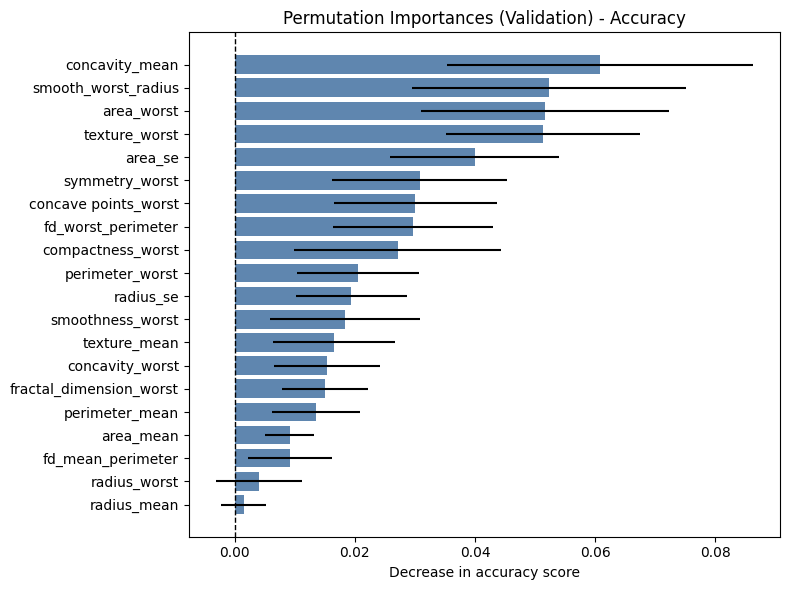

Baseline validation accuracy: 0.9890


,feature,importance_mean,importance_std
0,concavity_mean,0.060806,0.025494
1,smooth_worst_radius,0.052381,0.022820
2,area_worst,0.051648,0.020685
3,texture_worst,0.051282,0.016134
4,area_se,0.039927,0.014039
5,symmetry_worst,0.030769,0.014579
6,concave points_worst,0.030037,0.013588
7,fd_worst_perimeter,0.029670,0.013354
8,compactness_worst,0.027106,0.017197
9,perimeter_worst,0.020513,0.010125


In [44]:
df_val_eng = pd.read_csv(X_val_eng)
real_feature_names_eng = df_val_eng.columns.tolist()

imp_val_eng = permutation_importance_nn(
    model_eng, val_loader_eng,
    feature_names=real_feature_names_eng,
    n_repeats=30, random_state=42, n_jobs=-1
)

imp_val_eng.head(10)

### <span style="color: Orange;">**Section VII: Raw Features Training and Monitoring (RAW Pool)**</span>

- Initialize a GPU-accelerated Lightning trainer with mixed precision (16-bit autocast)
- Train the raw-features MLP under the same schedule and hyperparameters as the engineered pool
- Reuse the validation loop to monitor epoch-wise malignant-class recall

This section mirrors the engineered-features pipeline for the raw-features model. A PyTorch Lightning Trainer is configured with `precision='16-mixed'`, which applies automatic mixed precision to accelerate training while keeping model weights in FP32 for numerical stability. The raw-feature MLP is wrapped in the Lightning module and trained for a fixed number of epochs with identical optimizer and scheduler settings, ensuring a controlled comparison between feature pools. Validation proceeds identically, logging losses and accumulating malignant-class recall per epoch for downstream visualization and sensitivity analysis.


In [45]:
max_epochs = 20

model_raw = LitModel(
    RawModel(input_features=train_dataset_eng[0][0].shape[0], num_classes=2),
    learning_rate=1e-3,
    max_epochs=max_epochs
)

trainer_eng = L.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu',
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed',        
    logger=False,        
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    num_sanity_val_steps=0
)
trainer_eng.fit(model_raw, train_loader_raw, val_loader_raw)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Coding\bcd_mal\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:701: Checkpoint directory d:\Coding\bcd_mal\notebooks\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\bcd_mal\venv\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | RawModel | 139 K  | train
-------------------------------------------
139 K     Tr

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


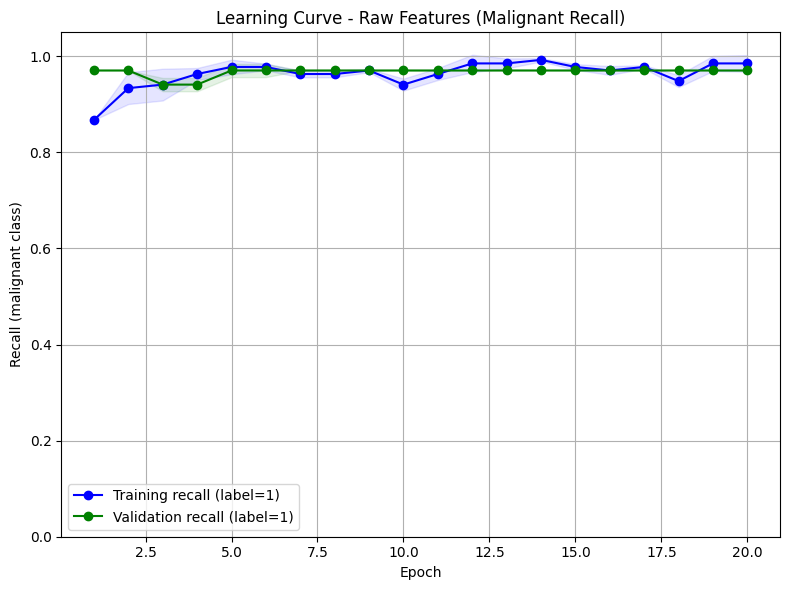

In [46]:
plot_epoch_learning_curve(
    model_raw.train_recall_mal_accum,
    model_raw.val_recall_mal_accum,
    title="Learning Curve - Raw Features (Malignant Recall)"
)

### <span style="color: Orange;">**Section VIII: Evaluation — Classification Reports (RAW Pool)**</span>

- Set the trained raw-features module to eval mode and disable gradients
- Infer over validation and test loaders, aggregating predictions and targets
- Print the scikit-learn classification report for Benign and Malignant classes

This section evaluates the raw-features model using the same reporting utility applied to the engineered pool. The procedure switches the Lightning module to evaluation mode, iterates over the specified dataloaders on the correct device, and collects batch-wise predictions and ground truth. The concatenated outputs are passed to scikit-learn’s classification_report to summarize precision, recall, F1-score, and support per class, along with aggregate metrics such as macro/weighted averages and accuracy, enabling an apples-to-apples comparison between feature pools.


In [47]:
y_val_true, y_val_pred = eval_classification_report(model_raw, val_loader_raw, set_name="Validation")
y_test_true, y_test_pred = eval_classification_report(model_raw, test_loader_raw, set_name="Test")


Validation Classification Report:
              precision    recall  f1-score   support

      Benign     0.9825    0.9825    0.9825        57
   Malignant     0.9706    0.9706    0.9706        34

    accuracy                         0.9780        91
   macro avg     0.9765    0.9765    0.9765        91
weighted avg     0.9780    0.9780    0.9780        91


Test Classification Report:
              precision    recall  f1-score   support

      Benign     0.9863    1.0000    0.9931        72
   Malignant     1.0000    0.9762    0.9880        42

    accuracy                         0.9912       114
   macro avg     0.9932    0.9881    0.9905       114
weighted avg     0.9913    0.9912    0.9912       114



### <span style="color: Orange;">**Section IX: Permutation Feature Importance (RAW Pool)**</span>

- Extract validation arrays and baseline accuracy from the raw-features loader
- Use a lightweight estimator wrapper to enable scikit-learn permutation importance
- Rank and visualize raw-feature importances with mean impact and variability

This section assesses the contribution of each raw feature using a permutation-based, model-agnostic approach on the validation split. After converting the dataloader to arrays and computing the baseline accuracy, the trained raw-feature Lightning module is exposed via a minimal predict-only wrapper to interface with scikit-learn’s permutation importance routine. The algorithm repeatedly shuffles each feature, measures the average decrease in accuracy, and summarizes results in a DataFrame and bar plot, allowing quick identification of raw inputs that most influence classification performance.

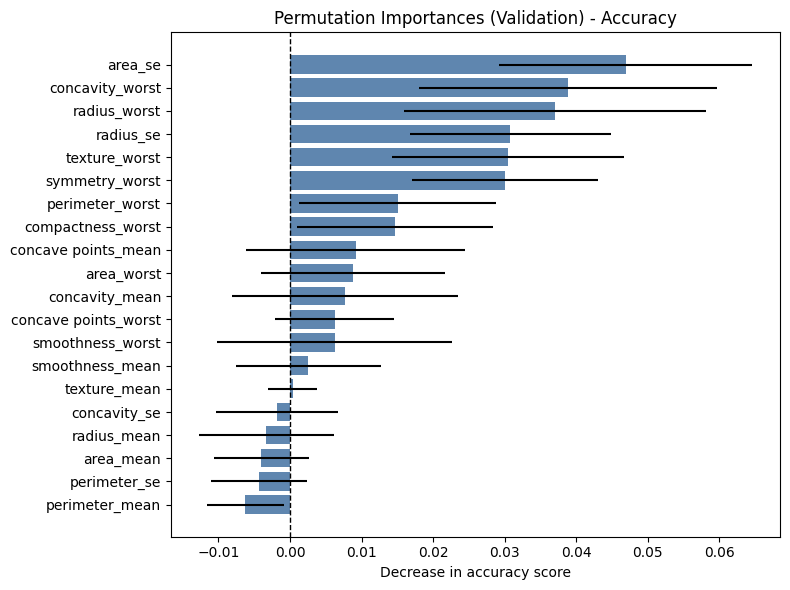

Baseline validation accuracy: 0.9780


,feature,importance_mean,importance_std
0,area_se,0.046886,0.017704
1,concavity_worst,0.038828,0.020799
2,radius_worst,0.036996,0.021135
3,radius_se,0.030769,0.014015
4,texture_worst,0.030403,0.016221
5,symmetry_worst,0.030037,0.012982
6,perimeter_worst,0.015018,0.013750
7,compactness_worst,0.014652,0.013706
8,concave points_mean,0.009158,0.015302
9,area_worst,0.008791,0.012815


In [48]:
df_val_raw = pd.read_csv(X_val_raw)
real_feature_names_raw = df_val_raw.columns.tolist()

imp_val_raw = permutation_importance_nn(
    model_raw, val_loader_raw,
    feature_names=real_feature_names_raw,
    n_repeats=30, random_state=42, n_jobs=-1
)

imp_val_raw.head(10)

### <span style="color: Orange;">**Section X: Feature Selection and Combined-Feature Training**</span>

- Select features by thresholding permutation-importance means from both pools
- Merge selected engineered and raw features into a unified, stable list
- Train a combined-feature MLP and evaluate learning curves and reports

This section operationalizes feature selection by applying a threshold to permutation-importance scores from both engineered and raw pools, yielding two subsets that are then unioned into a single, stable feature list for downstream modeling. Using this combined subset, new dataset objects and dataloaders are instantiated to ensure the training pipeline consumes only the most influential inputs, which can improve efficiency and generalization. A compact MLP classifier is defined for the merged feature space and trained under the same schedule and precision settings, after which malignant-class recall curves are visualized and detailed validation/test classification reports are produced to assess whether the fused representation improves sensitivity and overall performance.

In [49]:
def select_features_by_threshold(imp_df: pd.DataFrame, threshold: float):
    # expects columns: ["feature", "importance_mean", "importance_std"]
    sel = imp_df.loc[imp_df["importance_mean"] > threshold, "feature"].tolist()
    return sel

# Pick thresholds (tune based on plots/distribution of importances)
thr_eng = 0.03
thr_raw = 0.03

selected_features_eng = select_features_by_threshold(imp_val_eng, thr_eng)
selected_features_raw = select_features_by_threshold(imp_val_raw, thr_raw)

# Combine uniques while preserving a stable order (sorted or by first appearance)
combined_selected = sorted(set(selected_features_eng) | set(selected_features_raw))

print(f"Selected engineered features ({len(selected_features_eng)}): {selected_features_eng}")
print(f"Selected raw features ({len(selected_features_raw)}): {selected_features_raw}")
print(f"Combined unique selected features ({len(combined_selected)}): {combined_selected}")

Selected engineered features (7): ['concavity_mean', 'smooth_worst_radius', 'area_worst', 'texture_worst', 'area_se', 'symmetry_worst', 'concave points_worst']
Selected raw features (6): ['area_se', 'concavity_worst', 'radius_worst', 'radius_se', 'texture_worst', 'symmetry_worst']
Combined unique selected features (10): ['area_se', 'area_worst', 'concave points_worst', 'concavity_mean', 'concavity_worst', 'radius_se', 'radius_worst', 'smooth_worst_radius', 'symmetry_worst', 'texture_worst']


In [50]:
train_dataset_combined = CancerDataset(X_train, y_train, use_filter=True, feature_filter=combined_selected)
val_dataset_combined   = CancerDataset(X_val, y_val, use_filter=True, feature_filter=combined_selected)
test_dataset_combined  = CancerDataset(X_test, y_test, use_filter=True, feature_filter=combined_selected)

train_loader_combined = DataLoader(
    train_dataset_combined,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
val_loader_combined = DataLoader(
    val_dataset_combined,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
test_loader_combined = DataLoader(
    test_dataset_combined,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

In [51]:
# Model Definitions
class CombinedModel(nn.Module):
    def __init__(self, input_features, num_classes):
        super(CombinedModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.mlp(x)
        return x

In [52]:
max_epochs = 20

model_combined = LitModel(
    CombinedModel(input_features=train_dataset_combined[0][0].shape[0], num_classes=2),
    learning_rate=1e-3,
    max_epochs=max_epochs
)

trainer_combined = L.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu',
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed',        
    logger=False,        
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    num_sanity_val_steps=0
)
trainer_combined.fit(model_combined, train_loader_combined, val_loader_combined)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Coding\bcd_mal\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:701: Checkpoint directory d:\Coding\bcd_mal\notebooks\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\bcd_mal\venv\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | CombinedModel | 136 K  | train
-----------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


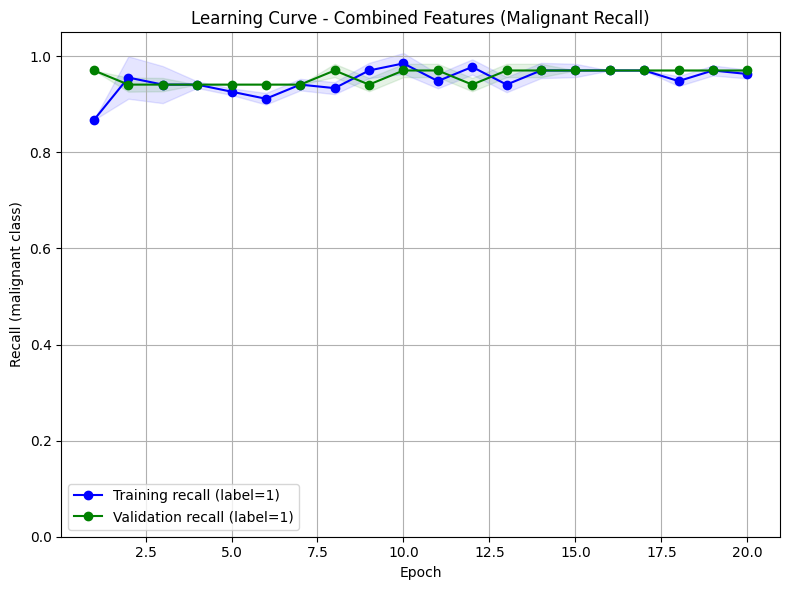

In [53]:
plot_epoch_learning_curve(
    model_combined.train_recall_mal_accum,
    model_combined.val_recall_mal_accum,
    title="Learning Curve - Combined Features (Malignant Recall)"
)

In [54]:
y_val_true, y_val_pred = eval_classification_report(model_combined, val_loader_combined, set_name="Validation")
y_test_true, y_test_pred = eval_classification_report(model_combined, test_loader_combined, set_name="Test")


Validation Classification Report:
              precision    recall  f1-score   support

      Benign     0.9828    1.0000    0.9913        57
   Malignant     1.0000    0.9706    0.9851        34

    accuracy                         0.9890        91
   macro avg     0.9914    0.9853    0.9882        91
weighted avg     0.9892    0.9890    0.9890        91


Test Classification Report:
              precision    recall  f1-score   support

      Benign     0.9726    0.9861    0.9793        72
   Malignant     0.9756    0.9524    0.9639        42

    accuracy                         0.9737       114
   macro avg     0.9741    0.9692    0.9716       114
weighted avg     0.9737    0.9737    0.9736       114

